# 1. Import and Hyper-Parameters

In [3]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from functions.method_choose import seg_method_choose, pre_method_choose

In [4]:
# input_folder = 'd:\\15 CT_data\\CPU_test\\'
input_folder = 'd:\\9-mysitewin\\DL\\ML funcs\\data\\origin\\'
# output_folder = 'd:\\15 CT_data\\CPU_test\\result'
out_folder = 'd:\\9-mysitewin\\DL\\ML funcs\\data\\result\\'
ROI = '0'
resize_dims = '0'

In [5]:
img_files = sorted([os.path.join(input_folder, f) for f in os.listdir(input_folder)
                    if f.endswith('.bmp') or f.endswith('.png')])
radius = int(ROI)

In [6]:
def calculate_hist(image):
    hist = cv2.calcHist([image], [0], None, [256], [0, 256])
    return hist


def calculate_pore(image, pre_name, seg_name):
    # Method chooses
    pro_processor = pre_method_choose(pre_name)
    segmentor, independent = seg_method_choose(seg_name)
    
    # Implement
    processed_image = pro_processor(image)
    seg_image = segmentor(processed_image)
    
    # Output
    if independent:
        # The independent methods' output is a [-1, ] image due to adopted to 3D images
        seg_image = seg_image.reshape(image.shape)
    if seg_name == 'origin':
        pore = None
    else:
        pore = np.sum(seg_image) / 255 / seg_image.shape[0] / seg_image.shape[1]
        
    return pore, processed_image, seg_image

# 2. Read Image

In [7]:
test_img = cv2.imread(img_files[8], cv2.IMREAD_GRAYSCALE)
height, width = test_img.shape
if radius != 0:
    test_img = test_img[(height // 2 - radius):(height // 2 + radius), (width // 2 - radius):(width // 2 + radius)]

# 3. Hist

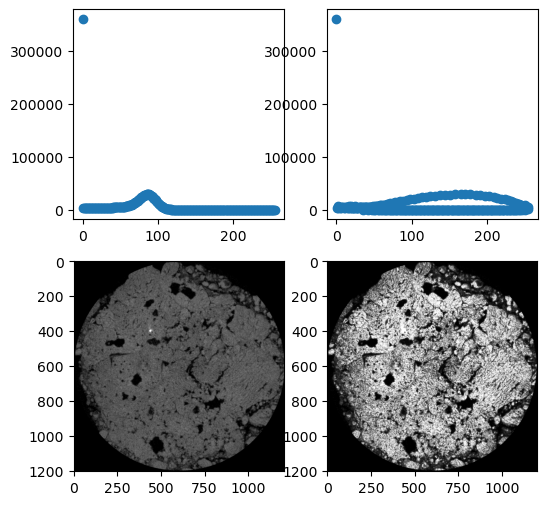

In [8]:
test_img_hist = calculate_hist(test_img)
test_img_equalized = cv2.equalizeHist(test_img)
test_img_equalized_hist = calculate_hist(test_img_equalized)

plt.figure(figsize=(6, 6))

plt.subplot(2, 2, 1)
plt.scatter(np.arange(256), test_img_hist)
plt.subplot(2, 2, 2)
plt.scatter(np.arange(256), test_img_equalized_hist)
plt.subplot(2, 2, 3)
plt.imshow(test_img, cmap='gray')
plt.subplot(2, 2, 4)
plt.imshow(test_img_equalized, cmap='gray')


# 4. Multiple Pre-process and Multi-Segmentations

In [9]:
pore_table = np.zeros([256, 3])

for i in range(256):
    _, threshold_img = cv2.threshold(test_img, i, 255, cv2.THRESH_BINARY)
    pore_table[i, 0] = i
    pore_table[i, 1] = np.sum(threshold_img/255) / threshold_img.shape[0] / threshold_img.shape[1]
    pore_table[i, 2] = 1 - pore_table[i, 1]

pore_table

array([[0.00000000e+00, 7.51369328e-01, 2.48630672e-01],
       [1.00000000e+00, 7.49016981e-01, 2.50983019e-01],
       [2.00000000e+00, 7.46775698e-01, 2.53224302e-01],
       [3.00000000e+00, 7.44532345e-01, 2.55467655e-01],
       [4.00000000e+00, 7.42362805e-01, 2.57637195e-01],
       [5.00000000e+00, 7.40329853e-01, 2.59670147e-01],
       [6.00000000e+00, 7.38367264e-01, 2.61632736e-01],
       [7.00000000e+00, 7.36415023e-01, 2.63584977e-01],
       [8.00000000e+00, 7.34492445e-01, 2.65507555e-01],
       [9.00000000e+00, 7.32578835e-01, 2.67421165e-01],
       [1.00000000e+01, 7.30762492e-01, 2.69237508e-01],
       [1.10000000e+01, 7.28937870e-01, 2.71062130e-01],
       [1.20000000e+01, 7.27129116e-01, 2.72870884e-01],
       [1.30000000e+01, 7.25355542e-01, 2.74644458e-01],
       [1.40000000e+01, 7.23593007e-01, 2.76406993e-01],
       [1.50000000e+01, 7.21834610e-01, 2.78165390e-01],
       [1.60000000e+01, 7.20058967e-01, 2.79941033e-01],
       [1.70000000e+01, 7.18225

[[       nan        nan        nan        nan]
 [0.65302121 0.65302121 0.44776341 0.65426706]
 [0.40013217 0.40013217 0.38258753 0.42501049]
 [0.34697879 0.34697879 0.55223659 0.34573294]
 [0.25098302 0.25098302 0.24863067 0.25099682]
 [0.66750643 0.66750643 0.5283006  0.66668345]]


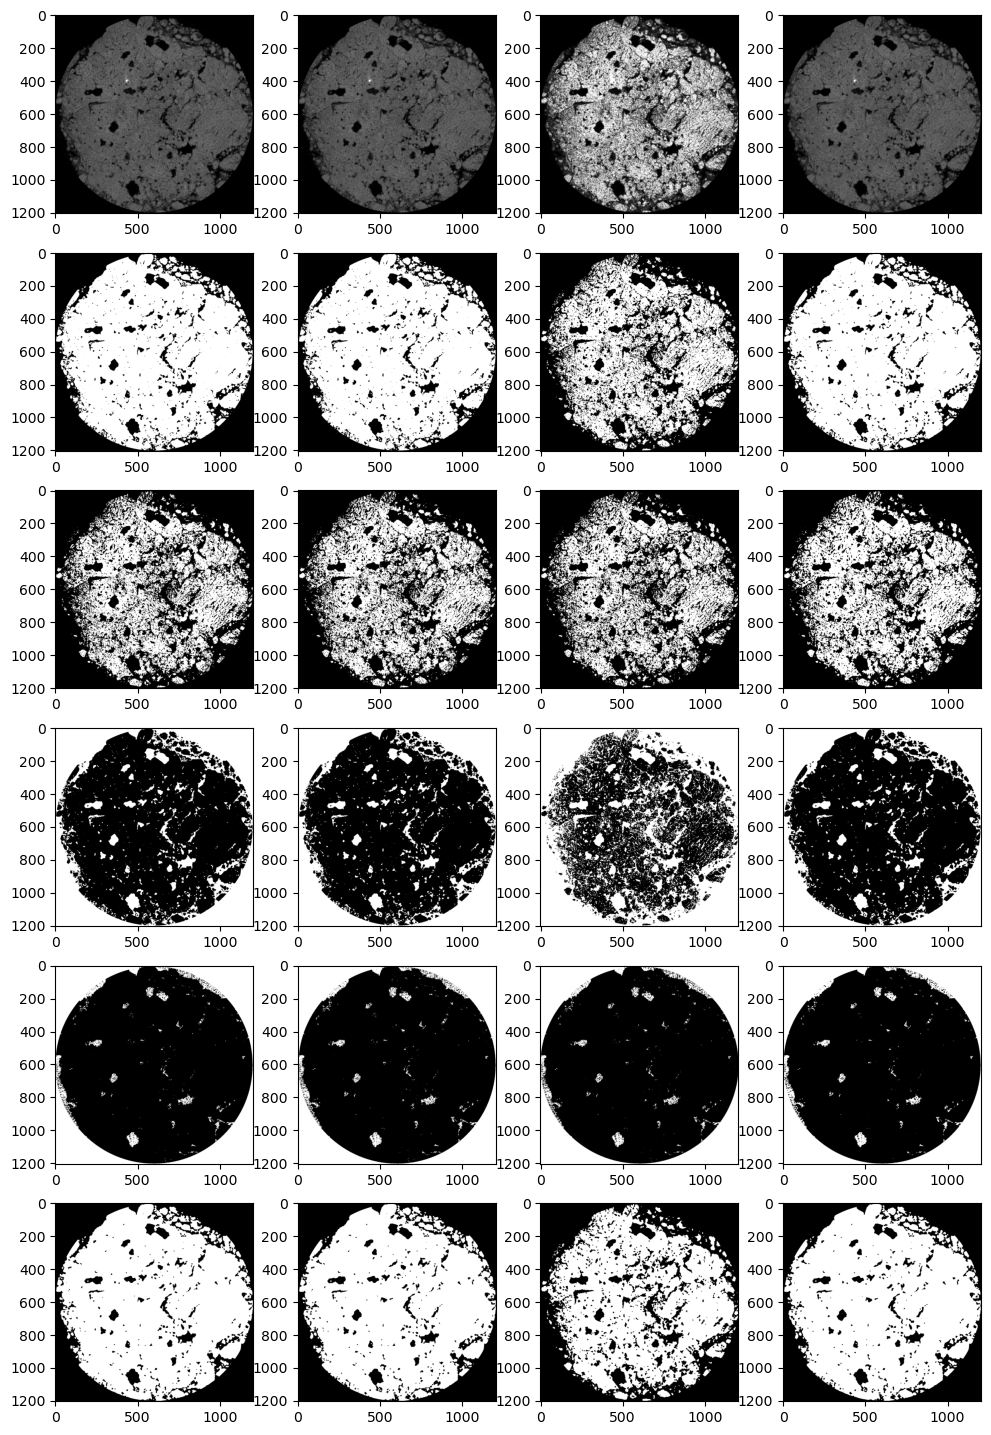

In [10]:
method_name_list = ['origin', 'otsu', 'kapur_entropy', 'kmeans', 'gmm', 'watershed']
pre_process_list = ['origin', 'gamma', 'equalized', 'median']

pore_list = np.zeros([len(method_name_list), len(pre_process_list)])
fig, ax = plt.subplots(len(method_name_list), len(pre_process_list), figsize=(12, 18))

for i, seg in enumerate(method_name_list):
    for j, pre_process in enumerate(pre_process_list):
        pore_percent, pre_processed, segmented = calculate_pore(test_img, pre_process, seg)
        pore_list[i, j] = pore_percent

        # 控制孔隙用哪一个标签表示
        # if np.sum(segmented) / 255 / (segmented.shape[0] ** 2) < 0.6:
        #     segmented = 255 - segmented
        #     pore_list[i, j] = 1 - pore_list[i, j]
        
        ax[i, j].imshow(segmented, cmap='gray')
    
print(pore_list)

# 4. Save a image

In [14]:
pore_percent, pre_processed, segmented = calculate_pore(test_img, 'origin', 'kmeans')
cv2.imwrite('origin.jpg', test_img)
cv2.imwrite('segmented.jpg', segmented)

True